In [15]:
import pandas as pd
from Bio import SeqIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from IPython.display import Image


### 
### This includes code copied and pasted from the main methods used for the website in BioKlustering-Website/BioKlustering/mlmodel/parser/kmeans.py
### These methods are copy-pasted instead of directly included due to difficulties importing Django classes for running locally without running the server
###

def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])

    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

def kmerXTable(s, a, b):
    tfid_vector = TfidfVectorizer(analyzer='char', ngram_range=(a,b))
    s_hat = tfid_vector.fit_transform(s.Sequence)
    kmerNames = tfid_vector.get_feature_names()
    kmers = s_hat.toarray()
    return pd.DataFrame(kmers,columns=kmerNames, index = s.index)
    
def kmeans(fasta, cNum, klength_min = 6, klength_max = 6, rNum = 50):
    inputData = parseFasta(fasta)
#     temp = virus01.append(inputData)
#     temp = temp.drop_duplicates(keep="last")
        
    inputData["Sequence"] = inputData["Sequence"].apply(lambda x: x.replace("-", ""))
    kmerXTableInput = kmerXTable(inputData, klength_min, klength_max)
        
        
    #km = KMeans(random_state = rNum, n_clusters = cNum)
    #m.fit(kmerXTableInput) 
    #y_hat = km.predict(kmerXTableInput)
    PCAembedding = PCA(n_components=10)
    NkmerXTableInput = preprocessing.normalize(kmerXTableInput)
    PCAembedding_low = PCAembedding.fit_transform(NkmerXTableInput)
    
    np.random.seed(rNum)
    ms = MeanShift()
    ms.fit(PCAembedding_low)
    cluster_centers = ms.cluster_centers_

    n_cluster_centers = len(cluster_centers)

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kmms = KMeans(init = cluster_centers, n_clusters = n_cluster_centers, random_state=rNum)
        #kmms = KMeans(init = 'k-means++', n_clusters = 2, n_init=20, max_iter=600)
        y_hat = kmms.fit_predict(PCAembedding_low)

    if n_cluster_centers > cNum:
        res = y_hat
        unique_predicted_labels = get_unique_numbers(res)
        predicted_labels_count = {}
        for label in unique_predicted_labels:
            predicted_labels_count[label] = (res == label).sum()
        max_item = max(predicted_labels_count, key=predicted_labels_count.get)
        predicted_labels_count = sorted(predicted_labels_count.items(), key=lambda x: x[1], reverse=True)
        map_predict_to_actual = {}
        max_value = cNum-1
        for i in range(len(predicted_labels_count)):
            if i < max_value:
                map_predict_to_actual[predicted_labels_count[i][0]] = i
            else:
                print(f"{predicted_labels_count[i][0]} mapped to {max_value}")
                map_predict_to_actual[predicted_labels_count[i][0]] = max_value

        # predictions_final contains the final results
        # it takes care of the case when num_class > number of unique labels given
        predictions_final = []
        print(f"map_predict_to_actual: {map_predict_to_actual}")
        for i in range(len(res)):
            if res[i] in map_predict_to_actual.keys():
                predictions_final.append(map_predict_to_actual[res[i]])
            else:
                predictions_final.append(map_predict_to_actual[max_item])
        print(predictions_final)
        y_hat = np.array(predictions_final)

        
    return y_hat, kmerXTableInput
        
def kmeans_semiSupervised(fasta, y_hat, klength_min = 6, klength_max = 6, rNum = 50, cNum=2):
    inputData = parseFasta(fasta)
    inputData["Sequence"] = inputData["Sequence"].apply(lambda x: x.replace("-", ""))
    kmerXTableInput = kmerXTable(inputData, klength_min, klength_max)
    
    PCAembedding = PCA(n_components=10)
    NkmerXTableInput = preprocessing.normalize(kmerXTableInput)
    PCAembedding_low = PCAembedding.fit_transform(NkmerXTableInput)
    
    np.random.seed(rNum)
    ms = MeanShift()
    ms.fit(PCAembedding_low)
    cluster_centers = ms.cluster_centers_

    n_cluster_centers = len(cluster_centers)

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kmms = KMeans(init = cluster_centers, n_clusters = n_cluster_centers, random_state=rNum)
        kmms_labels = kmms.fit_predict(PCAembedding_low)

    if n_cluster_centers > cNum:
        res = kmms_labels
        unique_predicted_labels = get_unique_numbers(res)
        predicted_labels_count = {}
        for label in unique_predicted_labels:
            predicted_labels_count[label] = (res == label).sum()
        max_item = max(predicted_labels_count, key=predicted_labels_count.get)
        predicted_labels_count = sorted(predicted_labels_count.items(), key=lambda x: x[1], reverse=True)
        map_predict_to_actual = {}
        max_value = cNum-1
        for i in range(len(predicted_labels_count)):
            if i < max_value:
                map_predict_to_actual[predicted_labels_count[i][0]] = i
            else:
                print(f"{predicted_labels_count[i][0]} mapped to {max_value}")
                map_predict_to_actual[predicted_labels_count[i][0]] = max_value

        # predictions_final contains the final results
        # it takes care of the case when num_class > number of unique labels given
        predictions_final = []
        print(f"map_predict_to_actual: {map_predict_to_actual}")
        for i in range(len(res)):
            if res[i] in map_predict_to_actual.keys():
                predictions_final.append(map_predict_to_actual[res[i]])
            else:
                predictions_final.append(map_predict_to_actual[max_item])
        kmms_labels = np.array(predictions_final)

     # convert all clusters into two clusters
    kmerXTableInput["pLabels"] = kmms_labels
    kmerXTableInput["aLabels"] = actual_labels = y_hat
    """
    newLabelsClusters = dict()
    unique_actual_labels = get_unique_numbers(kmerXTableInput["aLabels"])
    for actual_label in unique_actual_labels:
        newLabelsClusters[actual_label] = kmerXTableInput[kmerXTableInput["aLabels"] == actual_label]["pLabels"].tolist()

    unique_predicted_labels = get_unique_numbers(kmms_labels)
    new_labels_dict = dict()

    # Map the predicted labels to the given/actual labels
    for plabel in unique_predicted_labels:
        l = {}
        for key in newLabelsClusters.keys():
            if key != -1:
                l[key] = newLabelsClusters[key].count(plabel)
        new_labels_dict[plabel] = max(l, key=l.get)
    
    unknown_label = -1
    total_labeled = 0
    optimal_accuracy = 0
    for i in range(len(actual_labels)):
        if actual_labels[i] != unknown_label:
            total_labeled = total_labeled + 1

    correct_count = 0
    temp_accuracy = 0
    mid_labs = []
    for k in range(len(actual_labels)):
        mid_labs.append(new_labels_dict[kmms_labels[k]])
        if (actual_labels[k] != unknown_label):
            if (actual_labels[k] == new_labels_dict[kmms_labels[k]]):
                correct_count += 1
    temp_accuracy = correct_count / total_labeled
    if (temp_accuracy > optimal_accuracy):
        optimal_accuracy = temp_accuracy
    
    print("Optimal accuracy: ",temp_accuracy*100)

    # newLabels contains the final results
    newLabels = []
    for i in range(len(kmms_labels)):
        if actual_labels[i] == -1:
            newLabels.append(new_labels_dict[kmms_labels[i]])
        else:
           newLabels.append(actual_labels[i])
    """
    # Get the counts for the given labels and the predicted labels
    given_labels_count = {}
    labels_list = list(actual_labels)
    unique_given_labels = get_unique_numbers(actual_labels)
    predictions = kmms_labels
    for label in unique_given_labels:
        given_labels_count[label] = labels_list.count(label)
    unique_predicted_labels = get_unique_numbers(predictions)
    predicted_labels_count = {}
    for label in unique_predicted_labels:
        predicted_labels_count[label] = (predictions == label).sum()
    max_item = max(predicted_labels_count, key=predicted_labels_count.get)
    if -1 in given_labels_count.keys():
        del given_labels_count[-1]
    given_labels_count = sorted(given_labels_count.items(), key=lambda x: x[1], reverse=True)
    predicted_labels_count = sorted(predicted_labels_count.items(), key=lambda x: x[1], reverse=True)

    res = np.array(predictions)

    # Map the predicted labels to the given/actual labels
    map_predict_to_actual = {}
    for label_GIVEN_dict_entry in given_labels_count:
        label_GIVEN = label_GIVEN_dict_entry[0]
        predicted_labels_count_GIVEN = {}
        label_GIVEN_idx = [index for (index, item) in enumerate(labels_list) if item == label_GIVEN]
        res_GIVEN = [res[i] for i in label_GIVEN_idx]
        unique_predicted_labels_GIVEN = get_unique_numbers(res_GIVEN)
        for lab in unique_predicted_labels_GIVEN:
            predicted_labels_count_GIVEN[lab] = (res_GIVEN == lab).sum()
        map_predict_to_actual[max(predicted_labels_count_GIVEN, key=predicted_labels_count_GIVEN.get)] = label_GIVEN
            
    max_value = max(unique_given_labels) + 1
    for upl in unique_predicted_labels:
        if upl not in map_predict_to_actual.keys():
            print(f"{upl} mapped to {max_value}")
            map_predict_to_actual[upl] = max_value
            max_value += 1
    
    predictions_final = []
    predictions_tmp = []

    # predictions_final contains the final results
    # it takes care of the case when num_class > number of unique labels given
    for i in range(len(predictions)):
        if actual_labels[i] == -1:
            if predictions[i] in map_predict_to_actual.keys():
                predictions_final.append(map_predict_to_actual[predictions[i]])
                predictions_tmp.append(map_predict_to_actual[predictions[i]])
            else:
                predictions_final.append(map_predict_to_actual[max_item])
                predictions_tmp.append(map_predict_to_actual[max_item])
        else:
            predictions_tmp.append(map_predict_to_actual[predictions[i]])
            predictions_final.append(actual_labels[i])
    
    newLabels = predictions_final

    # get accuracy with regard to known labels

    unknown_label = -1
    total_labeled = 0
    for i in range(len(actual_labels)):
        if actual_labels[i] != unknown_label:
            total_labeled = total_labeled + 1

    correct_count = 0
    temp_accuracy = 0
    for k in range(len(actual_labels)):
        if (actual_labels[k] != unknown_label):
            if (actual_labels[k] == predictions_tmp[k]):
                correct_count += 1
    temp_accuracy = correct_count / total_labeled
    
    return newLabels, kmerXTableInput.drop(columns=["pLabels", "aLabels"]), kmms_labels
    
def PCA2d(kTable, y_hat, filename):
    embedding = PCA(n_components= 2)
    nkTable = preprocessing.normalize(kTable)
    embedding.fit(nkTable)
    show = pd.DataFrame(embedding.transform(nkTable))
    # show kmeans clustering
    show["labels"] = y_hat
    ax = show[show["labels"]==1].plot.scatter(x=0, y=1, style="o", color="red", s=2)
    show[show["labels"]==0].plot.scatter(x=0, y=1, style="o", color="blue", s=2, ax=ax)
    show[(show["labels"]!= 0) & (show["labels"]!= 1) ].plot.scatter(x=0, y=1, style="o", color="gray", s=2, ax=ax)
    red = mpatches.Patch(color='red', label='Label 1')
    blue = mpatches.Patch(color='blue', label='Label 0')
    grey = mpatches.Patch(color='grey', label='Label -1')
    plt.legend(handles=[red, blue, grey])
    plt.title('PCA Visualization')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.savefig('nonNotebookFiles/' + filename + '.png', bbox_inches='tight')
    plt.close()
    show.to_csv('nonNotebookFiles/' + filename + "_PCA.csv")
            
def tSNE2d(kTable, y_hat, filename):
    tSNEembedding = TSNE(n_components= 2, random_state = 0)
    tSNEembedding_low = tSNEembedding.fit_transform(kTable)
    show = pd.DataFrame(tSNEembedding_low)
    # show kmeans clustering
    show["labels"] = y_hat
    ax = show[show["labels"]==1].plot.scatter(x=0, y=1, style="o", color="red", s=2)
    show[show["labels"]==0].plot.scatter(x=0, y=1, style="o", color="blue", s=2, ax=ax)
    show[(show["labels"]!= 0) & (show["labels"]!= 1) ].plot.scatter(x=0, y=1, style="o", color="gray", s=2, ax=ax)
    red = mpatches.Patch(color='red', label='Label 1')
    blue = mpatches.Patch(color='blue', label='Label 0')
    grey = mpatches.Patch(color='grey', label='Label -1')
    plt.legend(handles=[red, blue, grey])
    plt.title('tSNE Visualization\n')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.savefig('nonNotebookFiles/' + filename + '.png', bbox_inches='tight')
    plt.close()
    show.to_csv('nonNotebookFiles/' + filename + "_tSNE.csv")

# this method credit to Zhiwen
def get_gene_sequences(filename):
    genes = []
    for record in SeqIO.parse(filename, "fasta"):
        genes.append(str(record.seq))
    return genes

# added helper method for semi-supervised labeling
def get_unique_numbers(numbers):

    list_of_unique_numbers = []

    unique_numbers = set(numbers)

    for number in unique_numbers:
        list_of_unique_numbers.append(number)

    return list_of_unique_numbers

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
#PATH1 = "../data/Sclerotinia_biocontrol_mycovirus_nucleotide.fasta"
#PATH01 = "../data/mycovirus_genbank_all_refseq_nucleotide_unique.fasta"

#virus1 = parseFasta(PATH1)
#virus01 = parseFasta(PATH01)
#virus01 = virus01.append(virus1)
#svirus01 = virus01.drop_duplicates(keep="last")

In [18]:
def model_selection(fasta,labels):
    best_accu = 0
    best_kmin = 0
    best_kmax = 0
    for kmin in range(5,9):
        for kmax in range(kmin,9):
            yhat, kmer, old = kmeans_semiSupervised(fasta,labels,kmin,kmax,50)
            d = {'real': labels, 'pred': old}
            df = pd.DataFrame(data=d)

            accu = len(df[(df['real'] != -1) & (df['real'] == df['pred'])])/len(df[df['real'] != -1])
            if accu > best_accu:
                best_accu = accu
                best_kmin = kmin
                best_kmax = kmax
    return best_accu,best_kmin,best_kmax


In [20]:
flu_data = "../validation-data/Semi-supervised-test-dataset/combined_Bat_Cat_flu.fa"

flu10_labels = pd.read_csv("../validation-data/Semi-supervised-test-dataset/labels_ten_percent.csv").Labels.tolist()
flu50_labels = pd.read_csv("../validation-data/Semi-supervised-test-dataset/labels_fifty_percent.csv").Labels.tolist()

flu_only0_labels = pd.read_csv("../validation-data/Semi-supervised-test-dataset/labels_ten_percent_only0s.csv").Labels.tolist()

flu50_labels

bat_len = len(get_gene_sequences("../validation-data/Semi-supervised-test-dataset/bat_flu.fa"))

cat_len = len(get_gene_sequences("../validation-data/Semi-supervised-test-dataset/cat_flu.fa"))

zeros = [0]*bat_len
true_labels = np.append(zeros, [1]*cat_len, axis=None)

In [21]:
accu, kmin, kmax = model_selection(flu_data, flu_only0_labels)
print("best accuracy 10% only 0s: ", accu, " kmin=", kmin, "  kmax=",kmax)


### since all achieve 100% accuracy, using kmin=5,kmax=7 to align with cases below
y_hat_only0, kmer_only0, old_only0 = kmeans_semiSupervised(flu_data, flu_only0_labels, 5, 7, 50)



#pd.set_option("display.max_rows", None, "display.max_columns", None)
#display(pd.DataFrame(list(zip(old_only0,y_hat_only0,true_labels,flu_only0_labels)),columns=['old','labels','actual','input']))


1 mapped to 1
2 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 2: 1}
1 mapped to 1
1 mapped to 1
2 mapped to 1
3 mapped to 1
4 mapped to 1
5 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
1 mapped to 1
1 mapped to 1
3 mapped to 1
2 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 3: 1, 2: 1, 4: 1, 5: 1, 6: 1}
1 mapped to 1
1 mapped to 1
2 mapped to 1
3 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}
1 mapped to 1
1 mapped to 1
3 mapped to 1
2 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 3: 1, 2: 1, 4: 1, 5: 1, 6: 1}
1 mapped to 1
1 mapped to 1
2 mapped to 1
3 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}
1 mapped to 1
1 mapped to 1
2 mapped to 1
3 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1:

In [22]:
accu, kmin, kmax = model_selection(flu_data, flu10_labels)
print("best accuracy 10%: ", accu, " kmin=", kmin, "  kmax=",kmax)

y_hat10, kmer10, old10 = kmeans_semiSupervised(flu_data, flu10_labels,  kmin, kmax, 50)

accu, kmin, kmax = model_selection(flu_data, flu50_labels)
print("best accuracy 50%: ", accu, " kmin=", kmin, "  kmax=",kmax)

y_hat50, kmer50, old50 = kmeans_semiSupervised(flu_data, flu50_labels, kmin, kmax, 50)

y_hat0, kmer0 = kmeans(flu_data, 2, 5, 7, 50)




#pd.set_option("display.max_rows", None, "display.max_columns", None)
#display(pd.DataFrame(list(zip(y_hat50,old50,flu50_labels)),columns=['labels','old','actual']))

#pd.set_option("display.max_rows", None, "display.max_columns", None)
#display(pd.DataFrame(list(zip(y_hat0,true_labels)),columns=['labels','actual']))

1 mapped to 1
2 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 2: 1}
1 mapped to 2
1 mapped to 1
2 mapped to 1
3 mapped to 1
4 mapped to 1
5 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
1 mapped to 2
1 mapped to 1
3 mapped to 1
2 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 3: 1, 2: 1, 4: 1, 5: 1, 6: 1}
1 mapped to 1
2 mapped to 1
3 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}
1 mapped to 2
1 mapped to 1
3 mapped to 1
2 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 3: 1, 2: 1, 4: 1, 5: 1, 6: 1}
1 mapped to 1
2 mapped to 1
3 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}
1 mapped to 2
1 mapped to 1
2 mapped to 1
3 mapped to 1
4 mapped to 1
5 mapped to 1
6 mapped to 1
map_predict_to_actual: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 

In [24]:
PCA2d(kmer_only0, flu_only0_labels, "real10_0")
PCA2d(kmer_only0, y_hat_only0, "test10_0")

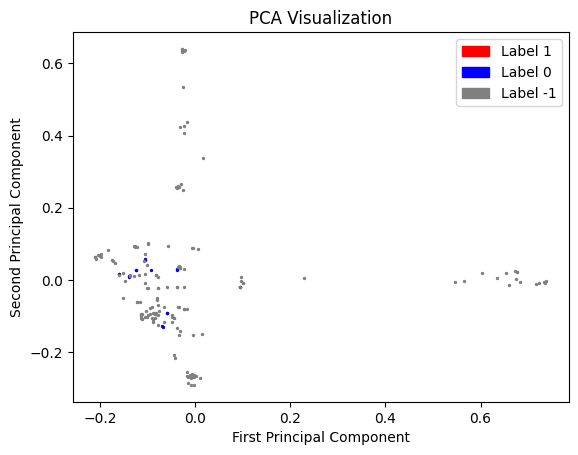

In [25]:
Image("nonNotebookFiles/real10_0.png")

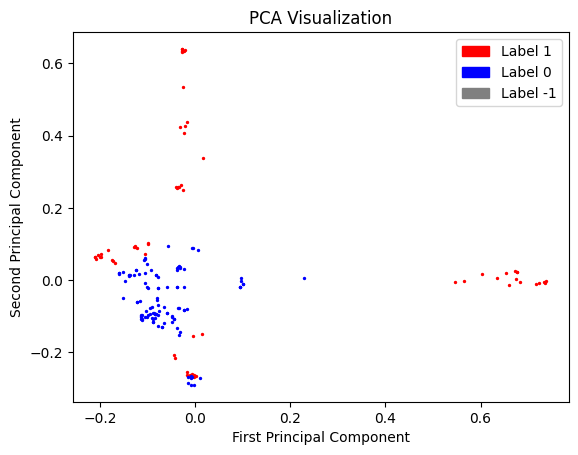

In [26]:
Image("nonNotebookFiles/test10_0.png")

In [27]:
donly0 = {'real10': flu_only0_labels, 'pred10': y_hat_only0}
dfonly20 = pd.DataFrame(data=donly0)

print("Known labels only:")
print(len(dfonly20[(dfonly20['real10'] != -1) & (dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20[dfonly20['real10'] != -1])*100)
print("\n 10 percent only 0s all labels:")
#print(len(dfonly20[(dfonly20['real10'] == dfonly20['pred10'])])/len(dfonly20['real10'])*100)
print(1 - sum(abs(true_labels - dfonly20['pred10']))/(len(true_labels)))

allzero = 1 - sum(abs(true_labels - dfonly20['pred10']))/(len(true_labels))

#pd.set_option("display.max_rows", None, "display.max_columns", None)
#display(pd.DataFrame(list(zip(true_labels,dfonly20['pred10'])),columns=['true','pred']))

Known labels only:
100.0

 10 percent only 0s all labels:
0.7134831460674158


In [28]:
PCA2d(kmer0, y_hat0, "test0")
PCA2d(kmer10, y_hat10, "test10")
PCA2d(kmer50, y_hat50, "test50")

PCA2d(kmer0, flu10_labels, "real10")
PCA2d(kmer0, flu50_labels, "real50")

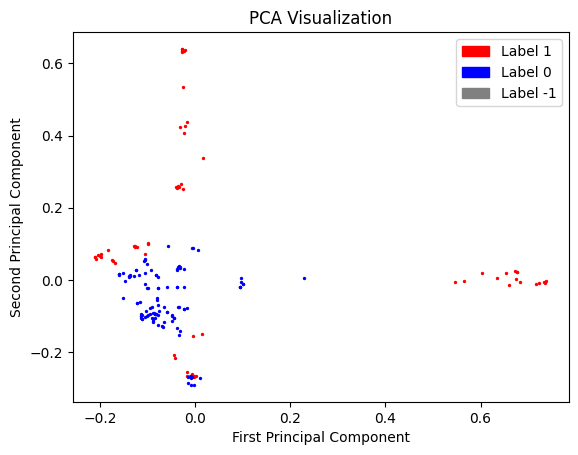

In [29]:
Image("nonNotebookFiles/test0.png")

In [30]:
d10 = {'real10': flu10_labels, 'pred10': y_hat10}
df10 = pd.DataFrame(data=d10)

print("known labels only:")
print(len(df10[(df10['real10'] != -1) & (df10['real10'] == df10['pred10'])])/len(df10[df10['real10'] != -1])*100)

print("\n 10 percent all labels:")
print(1 - sum(abs(true_labels - df10['pred10']))/(len(true_labels)))

ten = 1 - sum(abs(true_labels - df10['pred10']))/(len(true_labels))


known labels only:
100.0

 10 percent all labels:
0.7359550561797753


In [ ]:
Image("nonNotebookFiles/real10.png")

In [ ]:
Image("nonNotebookFiles/test10.png")

In [31]:
d50 = {'real50': flu50_labels, 'pred50': y_hat50}
df50 = pd.DataFrame(data=d50)

print("known labels only:")
print(len(df50[(df50['real50'] != -1) & (df50['real50'] == df50['pred50'])])/len(df50[df50['real50'] != -1]) * 100)

print("\n 50 percent all labels:")
print(1 - sum(abs(true_labels - df50['pred50']))/(len(true_labels)))

fifty = 1 - sum(abs(true_labels - df50['pred50']))/(len(true_labels))


known labels only:
100.0

 50 percent all labels:
0.8258426966292135


In [ ]:
Image("nonNotebookFiles/real50.png")

In [ ]:
Image("nonNotebookFiles/test50.png")

In [32]:
d0 = {'pred0': y_hat0}
df0 = pd.DataFrame(data=d0)

print("\n unsupervised all labels:")
print(1 - sum(abs(true_labels - df0['pred0']))/(len(true_labels)))

unsup = 1 - sum(abs(true_labels - df0['pred0']))/(len(true_labels))




 unsupervised all labels:
0.7134831460674158


In [33]:
print(unsup)
print(fifty)
print(ten)
print(allzero)

0.7134831460674158
0.8258426966292135
0.7359550561797753
0.7134831460674158


Without meanshift:
0.5449438202247191
0.6797752808988764
0.4157303370786517
0.449438202247191